In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from pandas.plotting import autocorrelation_plot

from scipy import stats
from statsmodels.tsa.arima_model import ARIMA

In [5]:
## Import data

path_in = './data/'
train_cols = ['date', 'store', 'item', 'sales']
train_dtypes = {'date': 'str', 'store': 'int', 'item': 'int', 'sales': 'int'}
parse_dates = ['date']

test_cols = ['date', 'store', 'item']
test_dtypes = {'date': 'str', 'store': 'int', 'item': 'int'}


train = pd.read_csv(path_in + 'train.csv', dtype = train_dtypes, parse_dates = ['date'], index_col = ['date'])
test = pd.read_csv(path_in + 'test.csv', dtype = test_dtypes, parse_dates = ['date'], index_col = ['date'])

In [6]:
train1_1 = train.loc[(train['store'] == 1) & (train['item'] == 1) & (train.index < '2017-01-01'), 'sales']
val1_1 = train.loc[(train['store'] == 1) & (train['item'] == 1) & (train.index >= '2017-01-01'), 'sales']


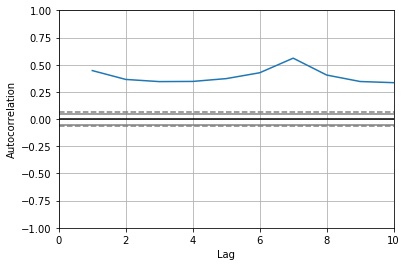

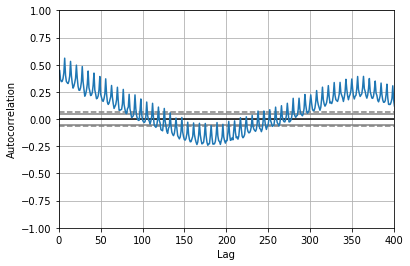

In [7]:
plt.figure(1)
autocorrelation_plot(train1_1)
plt.xlim(0, 10)
plt.figure(2)
autocorrelation_plot(train1_1)
plt.xlim(0, 400)
plt.show()

                             ARIMA Model Results                              
Dep. Variable:                D.sales   No. Observations:                 1460
Model:                 ARIMA(8, 1, 2)   Log Likelihood               -4428.480
Method:                       css-mle   S.D. of innovations              5.020
Date:                Tue, 18 Feb 2020   AIC                           8880.960
Time:                        13:11:19   BIC                           8944.394
Sample:                    01-02-2013   HQIC                          8904.623
                         - 12-31-2016                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0040      0.013      0.303      0.762      -0.022       0.030
ar.L1.D.sales    -0.8730      0.069    -12.602      0.000      -1.009      -0.737
ar.L2.D.sales    -0.0099      0.055     

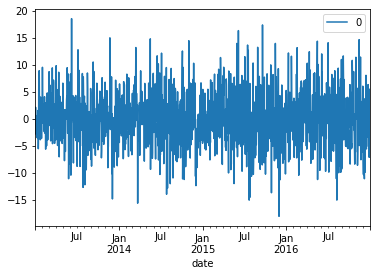

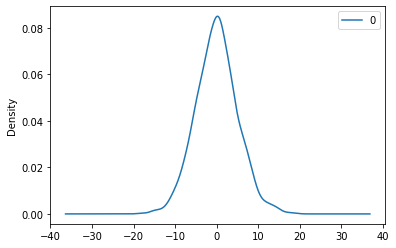

                 0
count  1460.000000
mean     -0.005620
std       5.022497
min     -18.052928
25%      -3.296630
50%      -0.015567
75%       3.125913
max      18.539794


In [8]:
# Fit model on ARIMA
model = ARIMA(train1_1, order = (8,1,2), freq = 'D')
model_fit = model.fit(disp = 0)
print(model_fit.summary())

# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind = 'kde')
plt.show()
print(residuals.describe())

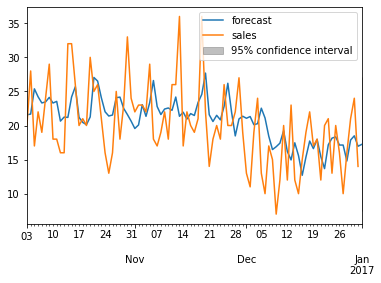

In [9]:
prediction = model_fit.plot_predict(len(train1_1)-90,len(train1_1))

In [10]:
prediction = model_fit.predict(n_periods = 37)
plt.plot(val1_1[0:90])

TypeError: predict() got an unexpected keyword argument 'n_periods'

In [ ]:
prediction

In [ ]:
val1_1[0]

In [ ]:
model_fit.forecast()

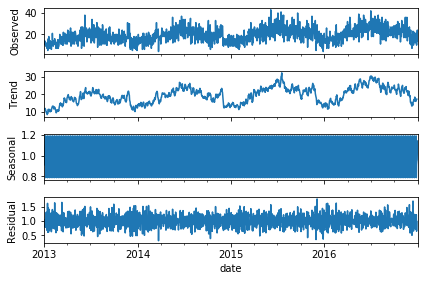

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(train1_1, model='multiplicative')
fig = result.plot()

In [ ]:
pip install chart_studio.plotly